In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt

import generate as generate
from single_layer import *

In [23]:
filename="../results.xlsx"

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

In [24]:
keep_ratio = 0.95

data = pd.read_excel(filename)
data = data[
    data.groupby(['d', 'M', 'T', 'noise', 'patience', 'epochs', 'lr'])['regret'].transform(
        lambda x : x <= x.quantile(keep_ratio)
    )
]
data = data.groupby(['d', 'M', 'T', 'noise', 'patience', 'epochs', 'lr']).agg(
    regret_mean=pd.NamedAgg(column="regret", aggfunc="mean"),
    regret_median=pd.NamedAgg(column="regret", aggfunc="median"),
    regret_std=pd.NamedAgg(column="regret", aggfunc="std"),
    count=pd.NamedAgg(column="regret", aggfunc="count"),
).reset_index()
data["regret_std"] /= np.sqrt(data["count"])
data["epsilon"] = data["regret_mean"] / (1 / 2 / data["noise"] / data["noise"])
data["epsilon_std"] = data["regret_std"] / (1 / 2 / data["noise"] / data["noise"])
data = data.sort_values(by=['noise', 'd', 'M', 'T'], ascending=True)
data.to_excel(f"../analysis{keep_ratio}.xlsx")
# data

In [25]:
data_new = data.loc[
    data.groupby(['d', 'M', 'T', 'noise'])['regret_mean'].idxmin()
].reset_index().set_index('T')
# data_new

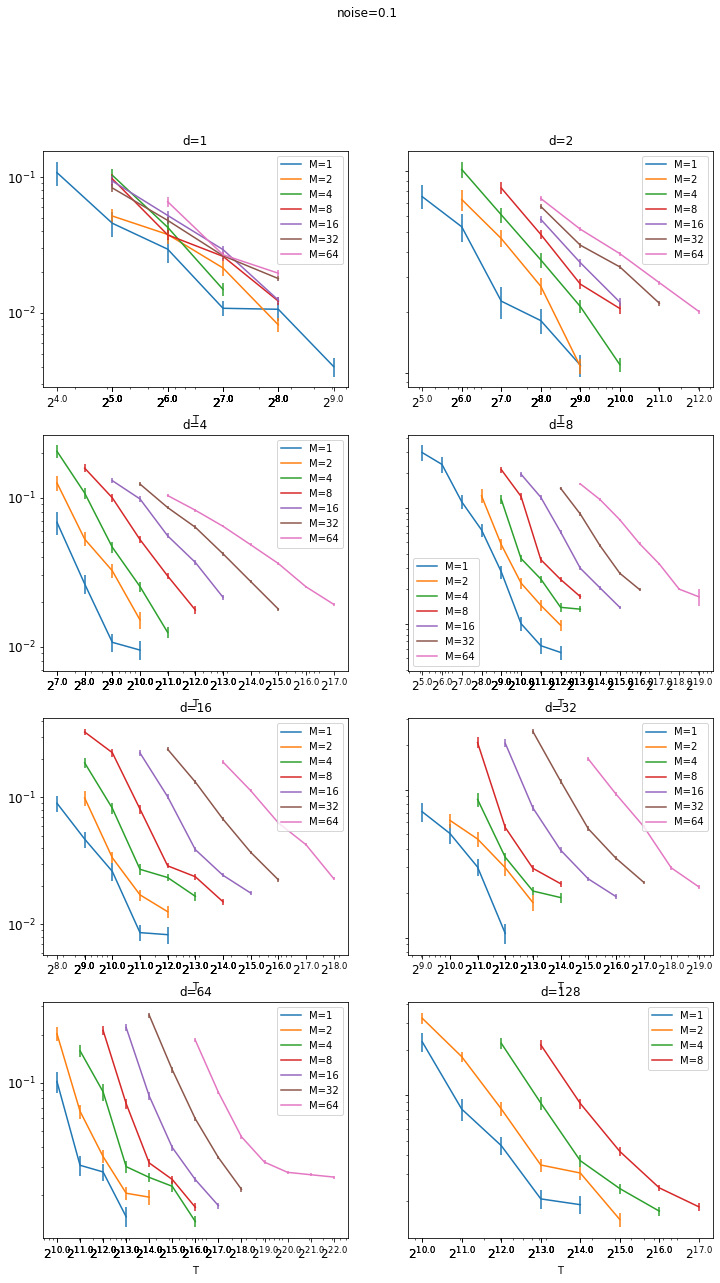

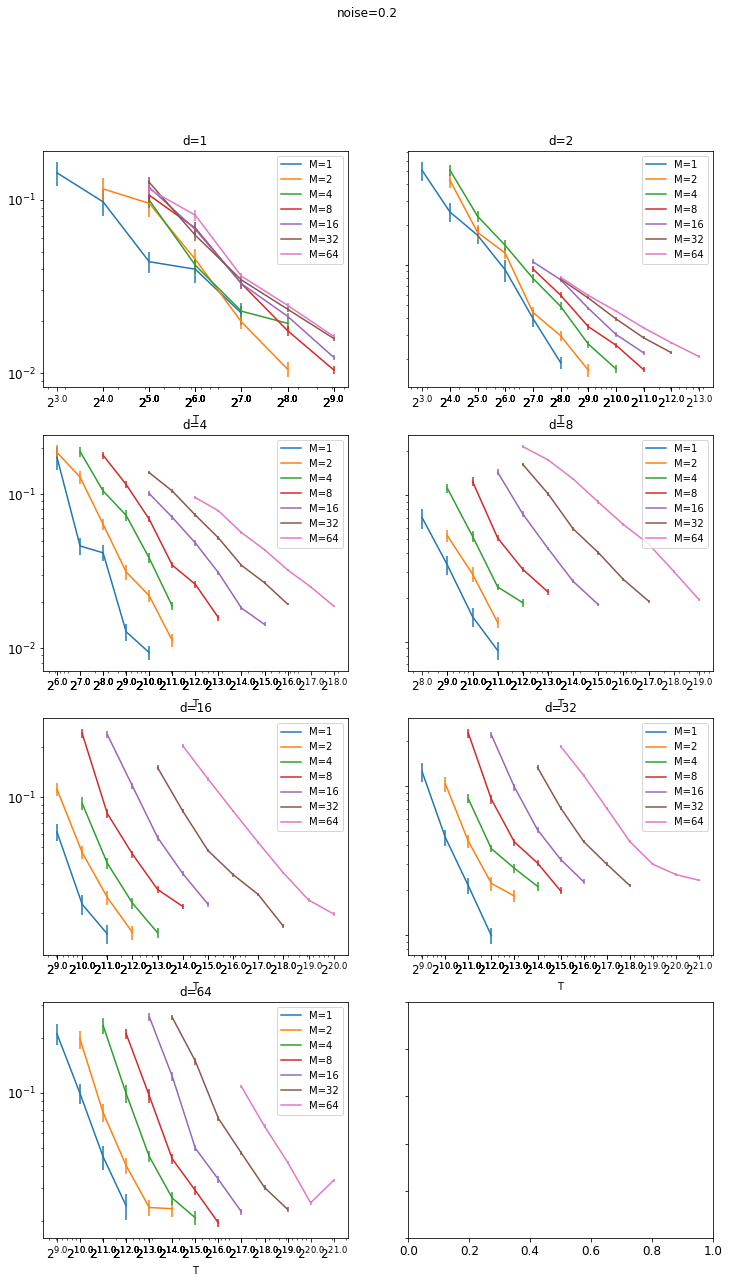

In [26]:
def to_exp_str(l):
    return [f"$2^{{{np.log2(x)}}}$" for x in l]

grouped_noise = data_new.groupby(['noise'])
for noise in grouped_noise.groups.keys():
    grouped_d = grouped_noise.get_group(noise).groupby(['d'])
    ncols = 2
    nrows = (len(grouped_d.groups) + ncols - 1) // ncols 
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*5))
    fig.suptitle(f"noise={noise}")
    for d, ax1 in zip(grouped_d.groups.keys(), axes.flatten()):
        grouped_d_M = grouped_d.get_group(d).groupby([
            'M'
        ])
        for key in grouped_d_M.groups.keys():
            grouped_d_M.get_group(key).plot(
                legend=True,
                logx=True,
                logy=True,
                ax=ax1,
                y='epsilon',
                yerr='epsilon_std',
                label=f'M={key}',
                sharey=True,
            )
        ax1.set_xticks(grouped_d.get_group(d).index.tolist())
        ax1.set_xticklabels(to_exp_str(
            grouped_d.get_group(d).index.tolist()
        ))
        # ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax1.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax1.set_title(f"d={d}")
    plt.show()

In [27]:
def get_T_e_max(data, epsilon):
    return data.where(data['epsilon'] < epsilon).groupby(['d', 'M', 'noise']).agg(
        T_e_max = pd.NamedAgg(column="T", aggfunc="min"),
    ).reset_index()
def get_T_e_min(data, epsilon):
    return data.where(data['epsilon'] > epsilon).groupby(['d', 'M', 'noise']).agg(
        T_e_min = pd.NamedAgg(column="T", aggfunc="max"),
    ).reset_index()

In [28]:
data_new = data.loc[
    data.groupby(['d', 'M', 'T', 'noise'])['regret_mean'].idxmin()
].reset_index()

In [29]:
def analyze_data(data, epsilon):
    temp = get_T_e_max(data, epsilon).merge(
        get_T_e_min(data, epsilon),
        on=['d', 'M', 'noise'],
        how='outer',
    )
    fig1, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.reshape(-1)

    def format_ax(ax):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    
    ax_cur = axes[0]
    grouped = temp.groupby("d")
    for d in grouped.groups.keys():
        cur_data = grouped.get_group(d)
        ax_cur.errorbar(
            x=cur_data['M'],
            y=(cur_data['T_e_max'] + cur_data['T_e_min'])/2,
            yerr=(cur_data['T_e_min'] - cur_data['T_e_max'])/2,
        )
    format_ax(ax_cur)
    ax_cur.set_xticks(data["M"].tolist())
    ax_cur.set_xticklabels(to_exp_str(data["M"].tolist()))
    ax_cur.set_yticks(data["T"].tolist())
    ax_cur.set_yticklabels(to_exp_str(data["T"].tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('M')
    ax_cur.set_ylabel('$T_\epsilon$')
    ax_cur.legend([f"d={d}" for d in grouped.groups.keys()])
    ax_cur.set_title(f"$M$ vs $T_\epsilon$ for different $d$")

    ax_cur = axes[1]
    grouped = temp.groupby("M")
    for d in grouped.groups.keys():
        cur_data = grouped.get_group(d)
        ax_cur.errorbar(
            x=cur_data['d'],
            y=(cur_data['T_e_max'] + cur_data['T_e_min'])/2,
            yerr=(cur_data['T_e_min'] - cur_data['T_e_max'])/2,
        )
    format_ax(ax_cur)
    ax_cur.set_xticks(data["d"].tolist())
    ax_cur.set_xticklabels(to_exp_str(data["d"].tolist()))
    ax_cur.set_yticks(data["T"].tolist())
    ax_cur.set_yticklabels(to_exp_str(data["T"].tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('d')
    ax_cur.set_ylabel('$T_\epsilon$')
    ax_cur.legend([f"M={m}" for m in grouped.groups.keys()])
    ax_cur.set_title(f"$d$ vs $T_\epsilon$ for different $M$")

    ax_cur = axes[2]
    ax_cur.scatter(
        temp["d"] * temp["M"], 
        temp["T_e_min"],
        alpha=0.3,
    )
    ax_cur.scatter(
        temp["d"] * temp["M"], 
        temp["T_e_max"],
        alpha=0.3,
    )
    format_ax(ax_cur)
    dM = (data["d"] * data["M"]).tolist()
    ax_cur.set_xticks(dM)
    ax_cur.set_xticklabels(to_exp_str(dM))
    ax_cur.set_yticks(data["T"].tolist())
    ax_cur.set_yticklabels(to_exp_str((data["T"]).tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('$M\\times d$')
    ax_cur.set_ylabel('$T_\epsilon$')
    ax_cur.legend(["min", "max"])
    ax_cur.set_title(f"$M\\times d$ vs $T_\epsilon$")
    return temp

        d     M  noise   T_e_max   T_e_min
0     1.0   1.0    0.1      32.0      16.0
1     1.0   2.0    0.1      64.0      32.0
2     1.0   4.0    0.1      64.0      32.0
3     1.0   8.0    0.1      64.0      32.0
4     1.0  16.0    0.1     128.0      64.0
5     1.0  32.0    0.1      64.0      32.0
6     1.0  64.0    0.1     128.0      64.0
7     2.0   1.0    0.1     128.0      64.0
8     2.0   2.0    0.1     128.0      64.0
9     2.0   4.0    0.1     256.0     128.0
10    2.0   8.0    0.1     256.0     128.0
11    2.0  16.0    0.1     512.0     256.0
12    2.0  32.0    0.1     512.0     256.0
13    2.0  64.0    0.1    1024.0     512.0
14    4.0   1.0    0.1     256.0     128.0
15    4.0   2.0    0.1     512.0     256.0
16    4.0   4.0    0.1     512.0     256.0
17    4.0   8.0    0.1    2048.0    1024.0
18    4.0  16.0    0.1    4096.0    2048.0
19    4.0  32.0    0.1    8192.0    4096.0
20    4.0  64.0    0.1   16384.0    8192.0
21    8.0   1.0    0.1     512.0     256.0
22    8.0  

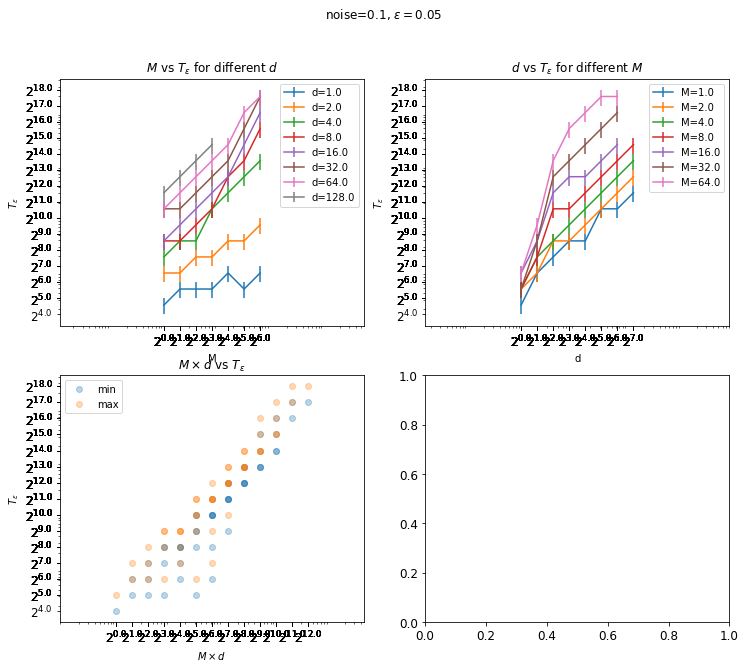

       d     M  noise   T_e_max   T_e_min
0    1.0   1.0    0.2      32.0      16.0
1    1.0   2.0    0.2      64.0      32.0
2    1.0   4.0    0.2      64.0      32.0
3    1.0   8.0    0.2     128.0      64.0
4    1.0  16.0    0.2     128.0      64.0
5    1.0  32.0    0.2     128.0      64.0
6    1.0  64.0    0.2     128.0      64.0
7    2.0   1.0    0.2     128.0      64.0
8    2.0   2.0    0.2     128.0      64.0
9    2.0   4.0    0.2     256.0     128.0
10   2.0   8.0    0.2     512.0     256.0
11   2.0  16.0    0.2     512.0     256.0
12   2.0  32.0    0.2    1024.0     512.0
13   2.0  64.0    0.2    1024.0     512.0
14   4.0   1.0    0.2     128.0      64.0
15   4.0   2.0    0.2     512.0     256.0
16   4.0   4.0    0.2    1024.0     512.0
17   4.0   8.0    0.2    2048.0    1024.0
18   4.0  16.0    0.2    4096.0    2048.0
19   4.0  32.0    0.2   16384.0    8192.0
20   4.0  64.0    0.2   32768.0   16384.0
21   8.0   1.0    0.2     512.0     256.0
22   8.0   2.0    0.2    1024.0   

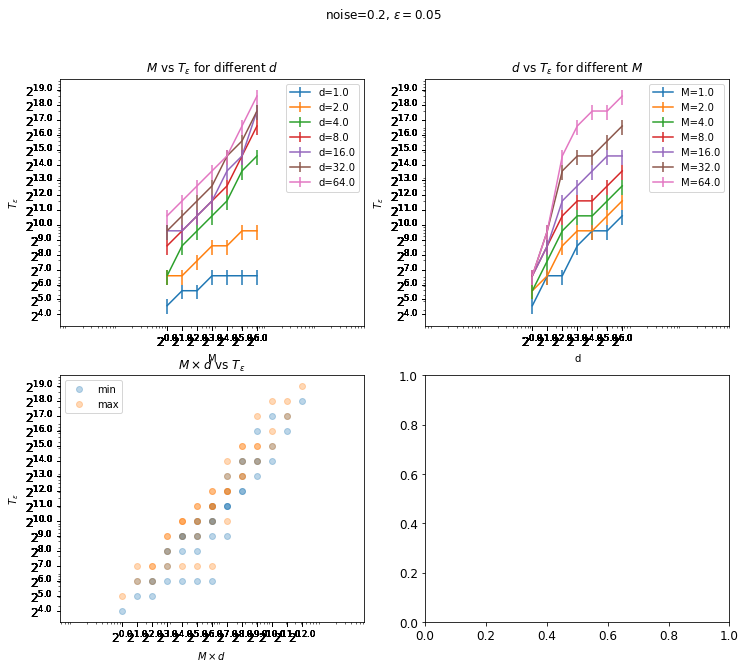

In [30]:
epsilon = 0.05
grouped_noise = data_new.groupby(['noise'])
for noise in grouped_noise.groups.keys():
    print(analyze_data(grouped_noise.get_group(noise), epsilon))
    plt.gcf().suptitle(f'noise={noise}, $\epsilon={epsilon}$')
    plt.show()

        d     M  noise   T_e_max    T_e_min
0     1.0   1.0    0.1     128.0       64.0
1     1.0   2.0    0.1     128.0       64.0
2     1.0   4.0    0.1     128.0       64.0
3     1.0   8.0    0.1     256.0      128.0
4     1.0  16.0    0.1     256.0      128.0
5     1.0  32.0    0.1     256.0      128.0
6     1.0  64.0    0.1     256.0      128.0
7     2.0   1.0    0.1     128.0       64.0
8     2.0   2.0    0.1     512.0      256.0
9     2.0   4.0    0.1     512.0      256.0
10    2.0   8.0    0.1    1024.0      512.0
11    2.0  16.0    0.1    1024.0      512.0
12    2.0  32.0    0.1    2048.0     1024.0
13    2.0  64.0    0.1    4096.0     2048.0
14    4.0   1.0    0.1     512.0      256.0
15    4.0   2.0    0.1    1024.0      512.0
16    4.0   4.0    0.1    2048.0     1024.0
17    4.0   8.0    0.1    4096.0     2048.0
18    4.0  16.0    0.1    8192.0     4096.0
19    4.0  32.0    0.1   32768.0    16384.0
20    4.0  64.0    0.1  131072.0    65536.0
21    8.0   1.0    0.1    1024.0

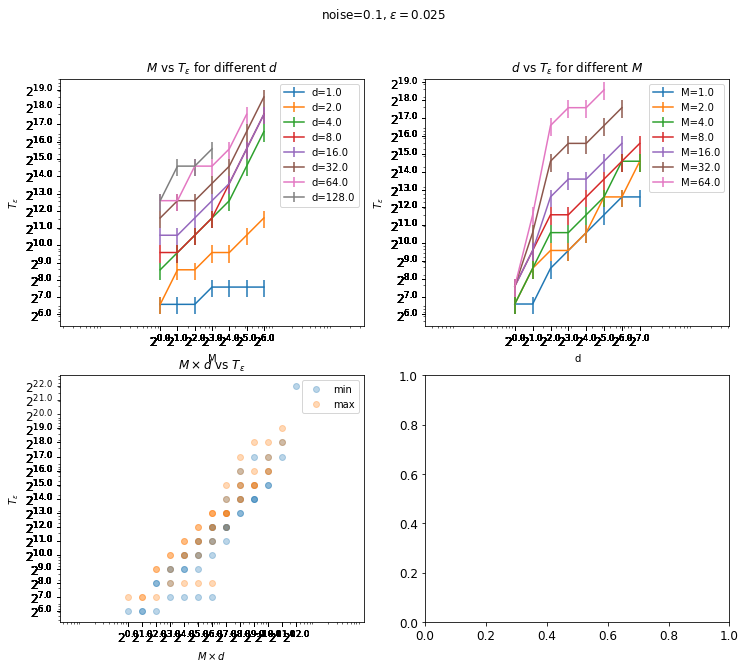

       d     M  noise    T_e_max    T_e_min
0    1.0   1.0    0.2      128.0       64.0
1    1.0   2.0    0.2      128.0       64.0
2    1.0   4.0    0.2      128.0       64.0
3    1.0   8.0    0.2      256.0      128.0
4    1.0  16.0    0.2      256.0      128.0
5    1.0  32.0    0.2      256.0      128.0
6    1.0  64.0    0.2      256.0      128.0
7    2.0   1.0    0.2      256.0      128.0
8    2.0   2.0    0.2      512.0      256.0
9    2.0   4.0    0.2     1024.0      512.0
10   2.0   8.0    0.2     2048.0     1024.0
11   2.0  16.0    0.2     2048.0     1024.0
12   2.0  32.0    0.2     4096.0     2048.0
13   2.0  64.0    0.2     8192.0     4096.0
14   4.0   1.0    0.2      512.0      256.0
15   4.0   2.0    0.2     1024.0      512.0
16   4.0   4.0    0.2     2048.0     1024.0
17   4.0   8.0    0.2     8192.0     4096.0
18   4.0  16.0    0.2    16384.0     8192.0
19   4.0  32.0    0.2    65536.0    32768.0
20   4.0  64.0    0.2   262144.0   131072.0
21   8.0   1.0    0.2     1024.0

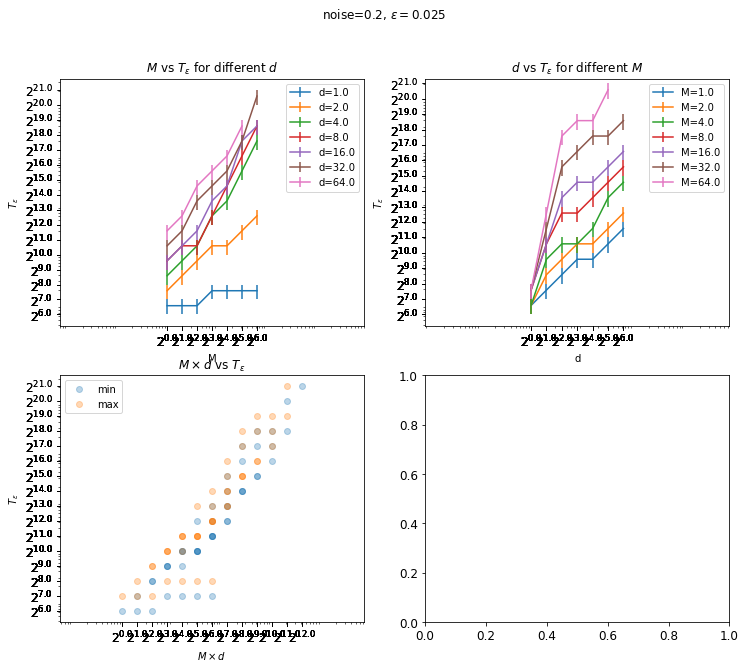

In [31]:
epsilon = 0.025
grouped_noise = data_new.groupby(['noise'])
for noise in grouped_noise.groups.keys():
    print(analyze_data(grouped_noise.get_group(noise), epsilon))
    plt.gcf().suptitle(f'noise={noise}, $\epsilon={epsilon}$')
    plt.show()

In [32]:
d = 32
M = 64
noise = 0.1
epsilon = 0.025
d * M * M * np.log(1 / (M * noise * noise * epsilon * np.log(1 + 1 / noise / noise) ))

341551.16297847516

In [33]:
data.columns

Index(['d', 'M', 'T', 'noise', 'patience', 'epochs', 'lr', 'regret_mean',
       'regret_median', 'regret_std', 'count', 'epsilon', 'epsilon_std'],
      dtype='object')

In [34]:
raw = pd.read_excel(filename)
raw = raw.groupby([ 
    "d",
    "M",
    "noise",
    "T",
]).agg(
    max_model=pd.NamedAgg(column="model", aggfunc="max"),
    mean_model=pd.NamedAgg(column="model", aggfunc="mean"),
    median_model=pd.NamedAgg(column="model", aggfunc="median"),
).reset_index()
raw["model_limit"] = 16 + np.minimum( 
    2 * np.sqrt(raw["T"]),
    2 * np.sqrt(raw["M"] * raw["d"]) + 2 * np.maximum(
        raw["M"], 
        raw["d"],
    ),
)

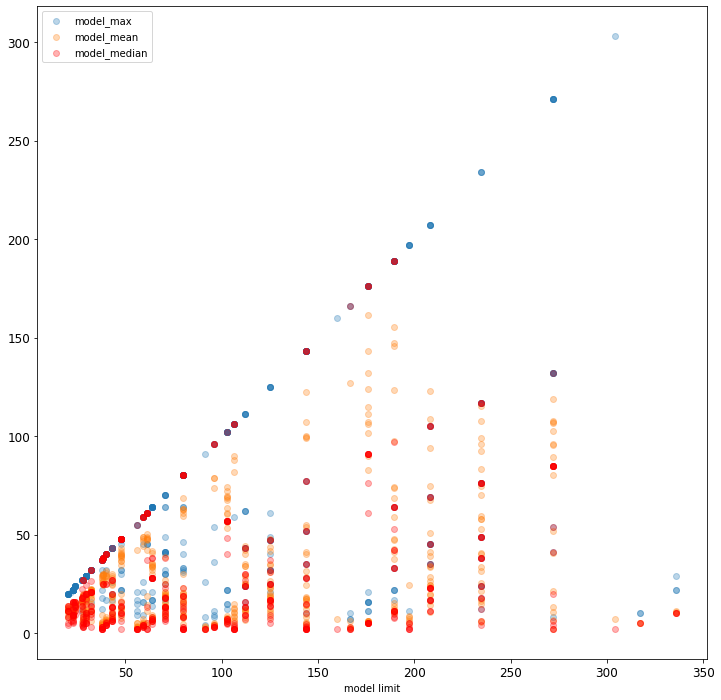

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
ax1.scatter(
    x = raw["model_limit"],
    y = raw["max_model"],
    alpha=0.3,
)
ax1.scatter(
    x = raw["model_limit"],
    y = raw["mean_model"],
    alpha=0.3,
)
ax1.scatter(
    x = raw["model_limit"],
    y = raw["median_model"],
    alpha=0.3,
    color="red",
)
ax1.legend(["model_max", "model_mean", "model_median"])
ax1.set_xlabel("model limit")
plt.show()

In [36]:
raw[ 
    raw["median_model"] == raw["model_limit"]
]

,d,M,noise,T,max_model,mean_model,median_model,model_limit
28,1,8,0.1,64,32,21.906250,32.0,32.0
32,1,8,0.2,64,32,21.843750,32.0,32.0
37,1,16,0.1,64,32,22.546875,32.0,32.0
39,1,16,0.1,256,48,39.687500,48.0,48.0
43,1,16,0.2,256,48,40.062500,48.0,48.0
48,1,32,0.1,256,48,38.765625,48.0,48.0
52,1,32,0.2,256,48,39.875000,48.0,48.0
56,1,64,0.1,256,48,36.437500,48.0,48.0
60,1,64,0.2,256,48,36.812500,48.0,48.0
96,2,8,0.1,256,40,31.421875,40.0,40.0


In [37]:
raw[ 
    (raw["M"] == 64)
    & (raw["d"] >= 32)
]

,d,M,noise,T,max_model,mean_model,median_model,model_limit
407,32,64,0.1,32768,38,21.500000,24.0,234.509668
408,32,64,0.1,65536,49,40.265625,38.0,234.509668
409,32,64,0.1,131072,117,74.781250,76.0,234.509668
410,32,64,0.1,262144,117,92.656250,76.0,234.509668
411,32,64,0.1,524288,234,107.843750,117.0,234.509668
412,32,64,0.2,32768,24,17.531250,18.0,234.509668
413,32,64,0.2,65536,49,33.312500,38.0,234.509668
414,32,64,0.2,131072,76,58.078125,49.0,234.509668
415,32,64,0.2,262144,117,83.093750,76.0,234.509668
416,32,64,0.2,524288,117,95.859375,76.0,234.509668
